## Find LR by sweeping 
Adapted from, inspired by
* https://github.com/SwayStar123/reimei/blob/main/best_lr.py
* [FastAI LR Finder](https://github.com/fastai/fastai/blob/f4de849baa79b64792ae5e98ef37e5f8fa4be66f/fastai/callback/schedule.py#L174)

Code below sweeps (finds) LR for a small diffusion model. You have to adapt it to your model and data. 

It will give you a plot that gradually goes down and suddenly up. The ideal LR for your model, data and batch size is somewhere before it starts going up.

In [1]:
import torch, os
from copy import deepcopy
from tqdm import tqdm

dtype = torch.bfloat16
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

In [2]:
# SINGLE STEP FUNCTION, adapt single_step() to your model

import torch.nn.functional as F

from diffusers import AutoencoderDC
from transformers import AutoModel, AutoTokenizer
from diffusers import SanaTransformer2DModel
from utils import (
    add_random_noise,
    encode_prompt
)

os.environ["TOKENIZERS_PARALLELISM"] = "false"

pipeline = dict(
    tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base", torch_dtype=dtype),
    text_encoder = AutoModel.from_pretrained("answerdotai/ModernBERT-base", torch_dtype=dtype).to(device),
    dcae = AutoencoderDC.from_pretrained("Efficient-Large-Model/Sana_600M_1024px_diffusers", subfolder="vae", torch_dtype=dtype).to(device),
)

def single_step(model, batch):
    labels, latents = batch

    # embed labels
    prompts_emb, prompts_atnmask = encode_prompt(labels, **pipeline, max_length=10)
    
    # Scale latent and add random amount of noise
    latents = latents.to(dtype).to(device)
    latents *=  pipeline["dcae"].config["scaling_factor"]
    latents_noisy, timestep, noise = add_random_noise(latents)

    # noise_pred = velocity
    noise_pred = model(
        hidden_states = latents_noisy.to(dtype), 
        encoder_hidden_states = prompts_emb, 
        encoder_attention_mask = prompts_atnmask,
        timestep = timestep, 
    ).sample

    return F.mse_loss(noise_pred, noise - latents)

/home/g/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


In [3]:
# Sweep LR for a given model and dataloader, this should be quite generic for any model
# Note: By default sweeps LR from 1e-6 to 10 
# Note: AdamW is optimizer, change to your needs

import gc 

def free_memory():
    gc.collect()
    torch.cuda.empty_cache()

# beta = smoothing factor for the loss
def sweep_LR(model, dataloader, ramp=True, init_lr = 1e-6, final_lr = 10, num_steps = 300, beta=0.98):
    # work with copy of model
    model = deepcopy(model).to(device)
    model.train()

    free_memory()
    optimizer = torch.optim.AdamW(model.parameters(), lr=init_lr)

    # Exponential LR multiplier
    lr_mult = (final_lr / init_lr) ** (1 / num_steps)
    lr = init_lr
    
    avg_loss, best_loss = 0.0, float("inf")
    lrs, losses = [], []
    step_count = 0

    for batch_idx, batch in enumerate(tqdm(dataloader, desc=f"sweep_LR, ramp {ramp}")):
        if step_count >= num_steps: break
        for param_group in optimizer.param_groups: param_group["lr"] = lr

        # loss and step
        loss = single_step(model, batch)
        optimizer.zero_grad()    
        loss.backward()
        optimizer.step()
    
        # Smooth the loss for stability
        avg_loss = beta * avg_loss + (1 - beta) * loss.item()
        smoothed_loss = avg_loss / (1 - beta ** (batch_idx + 1))
    
        # Track best loss
        if smoothed_loss < best_loss: best_loss = smoothed_loss
    
        lrs.append(lr)
        losses.append(smoothed_loss)
    
        # Stop if the loss diverges too much
        if batch_idx > 1 and smoothed_loss > 4 * best_loss:
            print("Loss diverged; stopping early.")
            break

        if ramp:
            lr *= lr_mult
        step_count += 1
        
    return lrs, losses

In [4]:
import matplotlib.pyplot as plt
import io
from PIL import Image

# Plot Sweep data, returns a PIL of plot
def visualize_sweeps(lr_sweeps, ylim_bottom = 1.5, ylim_top = 2.6):
    
    for label, (lr, loss) in lr_sweeps:
        plt.plot(lr, loss, label=label)
    
    plt.xscale("log")
    plt.xlabel("Learning Rate (log scale)")
    plt.ylabel("Smoothed Loss")
    
    # Adjust as desired
    plt.ylim(bottom=ylim_bottom, top=ylim_top)
    plt.title(f"LR Range Test")
    plt.legend()
    
    # Convert to PIL Image
    buffer = io.BytesIO()
    plt.savefig(buffer, format='PNG', bbox_inches='tight', dpi=100)
    buffer.seek(0)
    pil_image = Image.open(buffer)
    
    # plt.savefig(f"lr_search_{model_nickname}_bs-{bs}.png")
    # plt.show()
    plt.close()

    return pil_image

Loading dataset shards:   0%|          | 0/33 [00:00<?, ?it/s]

sweep_LR, ramp True:   1%|▏                            | 68/10009 [00:26<28:01,  5.91it/s]

Loss diverged; stopping early.


sweep_LR, ramp True:   1%|▏                          | 68/10009 [00:27<1:07:18,  2.46it/s]


Loading dataset shards:   0%|          | 0/33 [00:00<?, ?it/s]

sweep_LR, ramp True:   0%|                           | 35/10009 [00:12<1:17:39,  2.14it/s]

Loss diverged; stopping early.


sweep_LR, ramp True:   0%|                           | 35/10009 [00:13<1:02:07,  2.68it/s]


Loading dataset shards:   0%|          | 0/33 [00:00<?, ?it/s]

sweep_LR, ramp True:   0%|                              | 8/10009 [00:03<51:20,  3.25it/s]

Loss diverged; stopping early.


sweep_LR, ramp True:   0%|                            | 8/10009 [00:04<1:41:33,  1.64it/s]


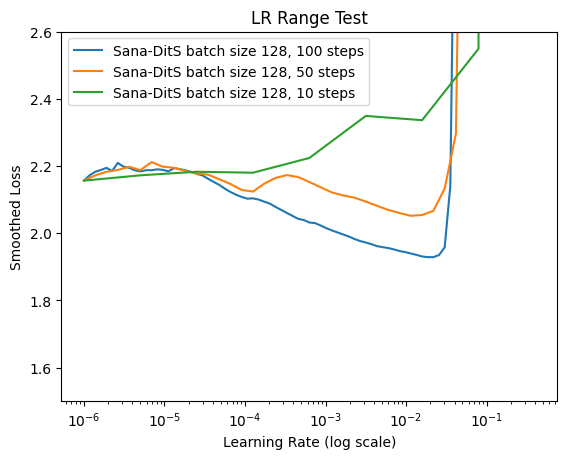

In [5]:
# Do the actual sweeping
# adapt model loading and dataloader to your needs

from utils import SanaDiTS, load_IN1k256px

model_nickname = "Sana-DitS"
model = SanaDiTS().to(dtype)
bs = 128
# try different numbers of steps, higher gives a smoother profile
# steps_list = [400, 200, 100, 50]
steps_list = [100, 50, 10]

lr_sweeps = []

for steps in steps_list:
    # fresh dataloader for each sweep
    dataloader, _ = load_IN1k256px(batch_size=bs)

    # sweep LR for given num of steps
    sweep_name = f"{model_nickname} batch size {bs}, {steps} steps"
    lrs, losses = sweep_LR(model, dataloader, num_steps=steps)
    
    lr_sweeps.append(
        (sweep_name, (lrs, losses))
    )

plot_pil = visualize_sweeps(lr_sweeps)
plot_pil.save(f"lr_search_{model_nickname}_bs-{bs}.png")
plot_pil